In [40]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt

In [3]:
# load datasets
user_engagement = pd.read_csv('takehome_user_engagement.csv')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [92]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


The "user_id" and "object_id" are the same thing here. This is what we can use to join the tables if needed.

Next, we should figure out how to identify adopted users. Meaning users that have logged into the product on three separate days in at least one seven-day period. 

In [93]:
# Count how many times each user logged in
num_visits = pd.DataFrame(user_engagement.user_id.value_counts())
num_visits = num_visits.rename(columns={'user_id':'num_logins'})
num_visits.head()

,num_logins
3623,606
906,600
1811,593
7590,590
8068,585


In [94]:
# join on users table
users = users.merge(num_visits, how='left', left_on='object_id', right_on=num_visits.index)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_logins
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0


In [47]:
df = user_engagement.copy()

In [48]:
# convert date column to datetime
df['time_stamp'] = pd.to_datetime(df.time_stamp)
df.time_stamp.dtype

dtype('<M8[ns]')

In [49]:
# define function to add up visits for user ids
def freq_count(df_group, frequency):
    return df_group.rolling(frequency, on='time_stamp')['user_id'].count()

In [50]:
# count up user frequency using rolling function with 7 day window size
df['visits_7'] = df.groupby('user_id', as_index=False, group_keys=False).apply(freq_count, '7D')

In [53]:
# identify adopted user rows
df[df.visits_7 >= 3.0]

,time_stamp,user_id,visited,visits_7
9,2014-02-09 03:45:04,2,1,3.0
10,2014-02-13 03:45:04,2,1,3.0
27,2013-02-19 22:08:03,10,1,3.0
30,2013-03-02 22:08:03,10,1,3.0
31,2013-03-05 22:08:03,10,1,3.0
...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,6.0
207899,2014-05-24 11:04:47,11988,1,6.0
207900,2014-05-26 11:04:47,11988,1,5.0
207901,2014-05-27 11:04:47,11988,1,5.0


In [65]:
adopted_users = df.groupby('user_id')['visits_7'].max().reset_index()

In [66]:
# make new binary column for adopted users
adopted_users['adopted_user'] = adopted_users['visits_7'].apply(lambda x: 1 if x>=3 else 0)

In [67]:
adopted_users.drop(['visits_7'], axis=1, inplace=True)

In [68]:
adopted_users.head()

,user_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [95]:
# join on users table
users = users.join(adopted_users, on='object_id', how='left')

In [96]:
users.drop(['user_id'], axis=1, inplace=True)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_logins,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0


Now that we have the adopted users identified, I am going to clean the data a bit and then find the most important features.

In [84]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  num_logins                  8823 non-null   float64
 11  adopted_user                8822 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.2+ MB


I need to convert creation time to datetime object, convert last session creation time to datetime object, one-hot encode creation source, drop the name and email columns, and fix the null values in last session creation time, invited by user id, num logins, and adopted user columns. 

In [97]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [98]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [99]:
dummy_cols = pd.get_dummies(users['creation_source'])
dummy_cols.head()

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [101]:
users_df = pd.concat([users, dummy_cols], axis=1)

In [102]:
users_df = users_df.drop(['creation_source', 'name', 'email'], axis=1)
users_df.head()

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_logins,adopted_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803.0,1.0,1.0,1,0,0,0,0
1,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,14.0,0.0,0,1,0,0,0
2,3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0.0,1,0,0,0,0
4,5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0,1,0,0,0,0


In [104]:
# fill last_session_creation_time, invited_by_user_id, and adopted_user with 0. fill num_logins with 1
users_df['last_session_creation_time'].fillna(0, inplace=True)
users_df['invited_by_user_id'].fillna(0, inplace=True)
users_df['adopted_user'].fillna(0, inplace=True)
users_df['num_logins'].fillna(1, inplace=True)

In [106]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   last_session_creation_time  12000 non-null  object        
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          12000 non-null  float64       
 7   num_logins                  12000 non-null  float64       
 8   adopted_user                12000 non-null  float64       
 9   GUEST_INVITE                12000 non-null  uint8         
 10  ORG_INVITE                  12000 non-null  uint8         
 11  PERSONAL_PROJECTS           12000 non-null  uint8     

All data cleaning is done. Now we can train a ML model and identify the most important features.

In [124]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

In [116]:
y = users_df['adopted_user']
X = users_df.drop(['adopted_user', 'creation_time', 'last_session_creation_time'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
cbc = CatBoostClassifier(random_state=42)
cbc.fit(X_train, y_train, silent=True)
y_train_pred = cbc.predict(X_train)
y_test_pred = cbc.predict(X_test)

In [122]:
# train results
print(confusion_matrix(y_train, y_train_pred))
print("Training set accuracy: " + str(accuracy_score(y_train, y_train_pred)))

[[8320    0]
 [1165  115]]
Training set accuracy: 0.8786458333333333


In [123]:
# test results
print(confusion_matrix(y_test, y_test_pred))
print("Testing set accuracy: " + str(accuracy_score(y_test, y_test_pred)))

[[2075    3]
 [ 322    0]]
Testing set accuracy: 0.8645833333333334


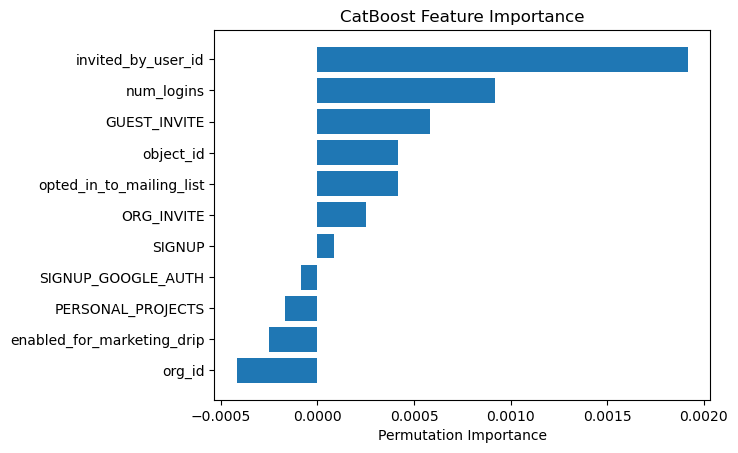

Top 5 features: ['invited_by_user_id' 'num_logins' 'GUEST_INVITE' 'object_id'
 'opted_in_to_mailing_list']


In [125]:
# find feature importance of CatBoost model
perm_importance = permutation_importance(cbc, X_test, y_test)
feature_names = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("CatBoost Feature Importance")
plt.xlabel("Permutation Importance")
plt.show()

print("Top 5 features: " + str(feature_names[np.flip(sorted_idx)][:5]))